In [1]:
import statistics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from lib.chaos import *
from lib.entropy import entropy_time_evolution
from scipy.signal import find_peaks
import matplotlib.patches as patches

plt.rcParams['font.family'] = 'Times New Roman' #全体のフォントを設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 15 # 全体のフォントサイズが変更されます。

Kuramoto model
 Estimated KS entropy: 0.30670929003899394
 Expected KS entropy: 0.3054719695558639
 KY dimension: 23.778124287494297
Coupled Lorenz
 Estimated KS entropy: 0.8281382165282962
 Expected KS entropy: 0.8591929334437104
 KY dimension: 4.038946209291824
N-dimensional Rossler
 Estimated KS entropy: 0.17458536495523397
 Expected KS entropy: 0.19590755910315402
 KY dimension: 8.02546017440766
Coupled Rossler
 Estimated KS entropy: 0.08982195489344
 Expected KS entropy: 0.09313006189944971
 KY dimension: 4.022134791980718


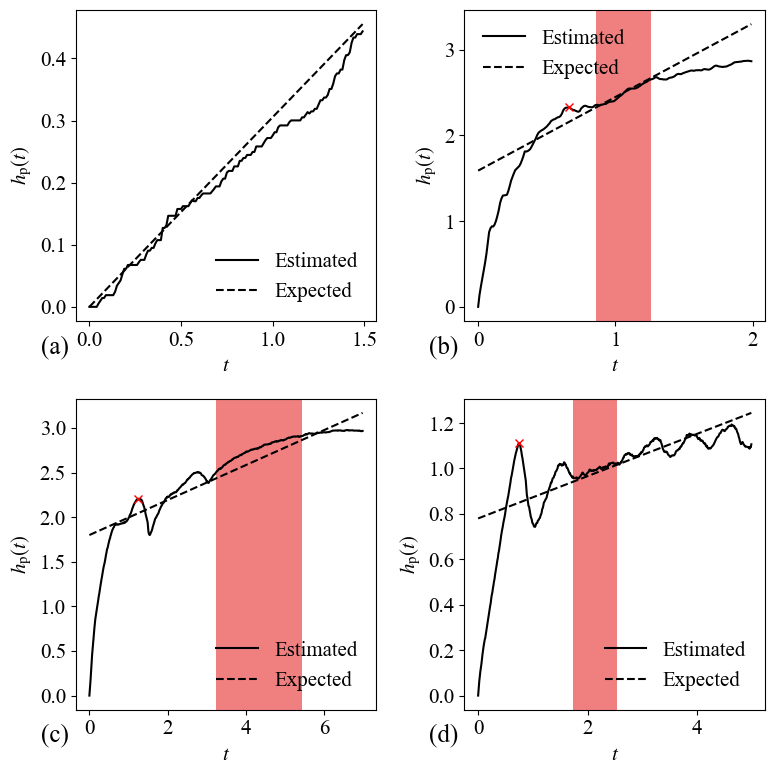

In [2]:
random_state = 0
prominence = 0.05

fig, axes = plt.subplots(2, 2, facecolor="white", figsize=(8, 8), tight_layout=True)

N = 32
omega = np.linspace(-1, 1, N)
K = 1.2
dt = 0.01
tend = 4000
cut = 100000
np.random.seed(0)
x0 = np.random.random(N)*2*np.pi #初期値は0から1の範囲で与える
tspan = np.arange(0, tend, dt)
system = Kuramoto_model(N, omega, K)
system.gen_time_series(x0, tspan, dt)
X = system.time_serie[cut:, :]
system.shimada_nagashima(X, dt, qr_step=1)
lyap = system.lyapunov_exponents
ks = sum(lyap[lyap>0])

dt = 0.01
k = 32
kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit(np.hstack([np.sin(X), np.cos(X)]))
labels = kmeans.labels_
tau_span = np.arange(0, 150, 1)
h = entropy_time_evolution(labels, tau_span)
interval = [0, 40]
idx = (interval[0] < tau_span) & (tau_span < interval[1])
print('Kuramoto model')
print(' Estimated KS entropy:', np.polyfit(tau_span[idx]*dt, h[idx], 1)[0])
print(' Expected KS entropy:', ks)
print(' KY dimension:', ky_dim(lyap))
axes[0, 0].plot(tau_span*dt, h, 'k', label='Estimated')
axes[0, 0].plot(tau_span*dt, tau_span*dt*ks, 'k--', label='Expected')
axes[0, 0].set_ylabel(r'$h_{\rm{p}}(t)$')
axes[0, 0].set_xlabel(r'$t$')
axes[0, 0].set_title('(a)', x=-0.07, y=-0.13)
axes[0, 0].legend(frameon=False, loc='lower right')



sigma = 10
r1 = 28
r2 = 28.8
b = 8/3
gamma = 3
dt = 0.01
tend = 4000
cut = 100000
np.random.seed(0)
x0 = np.random.random(6) #初期値は0から1の範囲で与える
tspan = np.arange(0, tend, dt)
system = Coupled_lorenz(sigma, r1, r2, b, gamma)
system.gen_time_series(x0, tspan, dt)
X = system.time_serie[cut:, :]
system.shimada_nagashima(X, dt, qr_step=1)
lyap = system.lyapunov_exponents
ks = sum(lyap[lyap>0])

time_delay = 10
dt = 0.01
k = 32
X = np.vstack([X[:-2*time_delay, 0], X[time_delay:-time_delay, 0], X[2*time_delay:, 0], 
               X[:-2*time_delay, 3], X[time_delay:-time_delay, 3], X[2*time_delay:, 3]]).T
kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit(X)
labels = kmeans.labels_
tau_span = np.arange(0, 200, 1)
h = entropy_time_evolution(labels, tau_span)
peaks, _ = find_peaks(h, prominence=prominence)
axes[0, 1].plot(tau_span*dt, h, 'k', label='Estimated')
axes[0, 1].plot(tau_span*dt, tau_span*dt*ks+1.59, 'k--', label='Expected')
axes[0, 1].plot(peaks[0]*dt, h[peaks[0]], "rx")
axes[0, 1].set_ylabel(r'$h_{\rm{p}}(t)$')
axes[0, 1].set_xlabel(r'$t$')
axes[0, 1].set_title('(b)', x=-0.07, y=-0.13)
axes[0, 1].legend(frameon=False)


interval = 140
segs_len = 20
threshold = 0.1

peak = peaks[0]
segs = np.arange(peak, interval+peak, segs_len)
slope = [np.polyfit(tau_span[i:i+segs_len]*dt, h[i:i+segs_len], 1)[0] for i in segs[:-1]]
region = [0]
for i in range(len(slope)-1):
    if abs(slope[i] - slope[i+1]) < threshold:
        region.append(region[-1])
    else:
        region.append(region[-1]+1)
md = statistics.mode(region)     
linear_region = [i for i, x in enumerate(region) if x == md]
start = linear_region[0]
end = linear_region[-1]
slope = np.polyfit(tau_span[segs[start]:segs[end]+segs_len]*dt, h[segs[start]:segs[end]+segs_len], 1)[0]
print('Coupled Lorenz')
print(' Estimated KS entropy:', slope)
print(' Expected KS entropy:', ks)
print(' KY dimension:', ky_dim(lyap))

min, max = axes[0, 1].get_ylim()
r = patches.Rectangle(xy=(segs[start]*dt, min), width=(segs[end]-segs[start]+segs_len)*dt, height=max-min, color='lightcoral', fill=True, linestyle='')
axes[0, 1].add_patch(r)


N = 9
a = 0.3
b = 4
d = 2
eps = 0.1
dt = 0.01
tend = 4000
cut = 100000
np.random.seed(0)
x0 = np.random.random(N) #初期値は0から1の範囲で与える
tspan = np.arange(0, tend, dt)
system = N_rossler(N, a, b, d, eps)
system.gen_time_series(x0, tspan, dt)
X = system.time_serie[cut:, :]
system.shimada_nagashima(X, dt, qr_step=1)
lyap = system.lyapunov_exponents
ks = sum(lyap[lyap>0])

time_delay = 150
dt = 0.01
k = 32
X = np.vstack([X[:-2*time_delay, 0], X[time_delay:-time_delay, 0], X[2*time_delay:, 0], 
               X[:-2*time_delay, 1], X[time_delay:-time_delay, 1], X[2*time_delay:, 1],
               X[:-2*time_delay, -1], X[time_delay:-time_delay, -1], X[2*time_delay:, -1]]).T
kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit(X)
labels = kmeans.labels_
tau_span = np.arange(0, 700, 1)
h = entropy_time_evolution(labels, tau_span)
peaks, _ = find_peaks(h, prominence=prominence)
axes[1, 0].plot(tau_span*dt, h, 'k', label='Estimated')
axes[1, 0].plot(tau_span*dt, tau_span*dt*ks+1.8, 'k--', label='Expected')
axes[1, 0].plot(peaks[0]*dt, h[peaks[0]], "rx")
axes[1, 0].set_ylabel(r'$h_{\rm{p}}(t)$')
axes[1, 0].set_xlabel(r'$t$')
axes[1, 0].set_title('(c)', x=-0.07, y=-0.13)
axes[1, 0].legend(frameon=False)


interval = 580
segs_len = 20
threshold = 0.1

peak = peaks[0]
segs = np.arange(peak, interval+peak, segs_len)
slope = [np.polyfit(tau_span[i:i+segs_len]*dt, h[i:i+segs_len], 1)[0] for i in segs[:-1]]
region = [0]
for i in range(len(slope)-1):
    if abs(slope[i] - slope[i+1]) < threshold:
        region.append(region[-1])
    else:
        region.append(region[-1]+1)
md = statistics.mode(region)     
linear_region = [i for i, x in enumerate(region) if x == md]
start = linear_region[0]
end = linear_region[-1]
slope = np.polyfit(tau_span[segs[start]:segs[end]+segs_len]*dt, h[segs[start]:segs[end]+segs_len], 1)[0]
print('N-dimensional Rossler')
print(' Estimated KS entropy:', slope)
print(' Expected KS entropy:', ks)
print(' KY dimension:', ky_dim(lyap))

min, max = axes[1, 0].get_ylim()
r = patches.Rectangle(xy=(segs[start]*dt, min), width=(segs[end]-segs[start]+segs_len)*dt, height=max-min, color='lightcoral', fill=True, linestyle='')
axes[1, 0].add_patch(r)


a = 0.2
f = 0.2
c = 4.5
omega1 = 0.97 + 0.02
omega2 = 0.97 - 0.02
eps = 0.01
dt = 0.01
tend = 4000
cut = 100000
np.random.seed(0)
x0 = np.random.random(6) #初期値は0から1の範囲で与える
tspan = np.arange(0, tend, dt)
system = Coupled_rossler(a, f, c, omega1, omega2, eps)
system.gen_time_series(x0, tspan, dt)
X = system.time_serie[cut:, :]
system.shimada_nagashima(X, dt, qr_step=1)
lyap = system.lyapunov_exponents
ks = sum(lyap[lyap>0])

time_delay = 100
dt = 0.01
k = 32
X = np.vstack([X[:-2*time_delay, 0], X[time_delay:-time_delay, 0], X[2*time_delay:, 0], 
               X[:-2*time_delay, 3], X[time_delay:-time_delay, 3], X[2*time_delay:, 3]]).T
kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit(X)
labels = kmeans.labels_
tau_span = np.arange(0, 500, 1)
h = entropy_time_evolution(labels, tau_span)
peaks, _ = find_peaks(h, prominence=prominence)
axes[1, 1].plot(tau_span*dt, h, 'k', label='Estimated')
axes[1, 1].plot(tau_span*dt, tau_span*dt*ks+0.78, 'k--', label='Expected')
axes[1, 1].plot(peaks[0]*dt, h[peaks[0]], "rx")
axes[1, 1].set_ylabel(r'$h_{\rm{p}}(t)$')
axes[1, 1].set_xlabel(r'$t$')
axes[1, 1].set_title('(d)', x=-0.07, y=-0.13)
axes[1, 1].legend(frameon=False)


interval = 400
segs_len = 20
threshold = 0.1

peak = peaks[0]
segs = np.arange(peak, interval+peak, segs_len)
slope = [np.polyfit(tau_span[i:i+segs_len]*dt, h[i:i+segs_len], 1)[0] for i in segs[:-1]]
region = [0]
for i in range(len(slope)-1):
    if abs(slope[i] - slope[i+1]) < threshold:
        region.append(region[-1])
    else:
        region.append(region[-1]+1)
md = statistics.mode(region)     
linear_region = [i for i, x in enumerate(region) if x == md]
start = linear_region[0]
end = linear_region[-1]
slope = np.polyfit(tau_span[segs[start]:segs[end]+segs_len]*dt, h[segs[start]:segs[end]+segs_len], 1)[0]
print('Coupled Rossler')
print(' Estimated KS entropy:', slope)
print(' Expected KS entropy:', ks)
print(' KY dimension:', ky_dim(lyap))

min, max = axes[1, 1].get_ylim()
r = patches.Rectangle(xy=(segs[start]*dt, min), width=(segs[end]-segs[start]+segs_len)*dt, height=max-min, color='lightcoral', fill=True, linestyle='')
axes[1, 1].add_patch(r)